In [1]:
import random,os,csv,glob,math,logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import keras.backend as K
import json
import numpy as np
import pandas as pd
import scipy.io
import cv2 as cv
from matplotlib import pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # NOQA

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from keras.preprocessing import image
import numpy as np
from google.colab.patches import cv2_imshow
from keras.activations import relu
from numpy import linspace

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate,LeakyReLU,Input, Dropout,Lambda,Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalAveragePooling1D,multiply
from tensorflow.keras.layers import Conv3D, MaxPooling3D

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers  
from tensorflow.keras.callbacks import TensorBoard  
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
#train, test split할 인덱스 불러오기

#arr = np.load('./arr.npy')
#plt.rcParams["figure.figsize"] = (7,2)
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['font.size']=10
#plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False

Using TensorFlow backend.


In [0]:
src = '/content/drive/My Drive/졸업연구/학습모델/'

In [0]:
model_path = '/content/drive/My Drive/졸업연구/학습모델/ours_v3_mse_log.h5'

In [4]:
temp = []
number = 1006
vox_files = os.listdir(src+'voxel_npz/')
#파일을 오름차순으로 불러와 파일명을 리스트에 저장합니다. 
for i in range(len(vox_files)):    
    for file in vox_files:
        filename_split = file.split('_')
        if str(i) == filename_split[0]:    
            temp.append(file)
#정렬된 파일명을 불러오는 용도로 사용합니다.
vox_files = temp
voxels = []
for file in tqdm(vox_files[:number]):
    vox= np.load(src+'voxel_npz/'+file)
    voxels.append(vox['x'])
voxels = np.asarray(voxels)
vox_sp=voxels.shape
vox_list=voxels.reshape(vox_sp[0],vox_sp[1],vox_sp[2],vox_sp[3],1)

100%|██████████| 1006/1006 [00:01<00:00, 686.99it/s]


In [17]:
df = pd.read_excel(src+'확인완료_MyParts(1~1000).xlsx')
#라벨 csv데이터 불러오기
y_unit, y_mat, y_vol,y_name =np.asarray(df['단가'])[:number],np.asarray(df['인코딩'])[:number],np.asarray(df['부피'])[:number],np.asarray(df['형번'])[:number]
# mat onehot
def LogScaler(array):
    return np.log10(array)
mat = to_categorical(y_mat,num_classes=24)
unit = LogScaler(y_unit)
vol = LogScaler(y_vol)
print(mat.shape,unit.shape,vol.shape)

(1006, 24) (1006,) (1006,)
[3.27779011 2.87169581 3.25029157 ... 2.3078337  2.3078337  2.3078337 ]


In [18]:
y_unit_sort = sorted(y_unit)
print(len(y_unit_sort))
idx=[]
y_unit_backup = y_unit.tolist()
for u in y_unit_sort:
  i = y_unit_backup.index(u)
  idx.append(i)
  y_unit_backup[i] = 'pass'

1006


In [0]:
# ** baseline1 : A Convolutional Neural Network Model for 
#Predicting a Product's Function, Given Its Form

def ours_v3():
    input1 = Input(shape=(32,32,32,1))
    x1 = Conv3D(16,(3,3,3),kernel_initializer='he_normal')(input1)
    x1 = Conv3D(16,(3,3,3),kernel_initializer='he_normal')(x1)
    x1 = MaxPooling3D((2,2,2))(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.3)(x1)
    
    x1 = Conv3D(32,(3,3,3),kernel_initializer='he_normal')(x1)
    x1 = Conv3D(32,(3,3,3),kernel_initializer='he_normal')(x1)
    x1 = MaxPooling3D((2,2,2),name='last_maxpool')(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.3)(x1)
    
    x1 = Conv3D(64,(3,3,3),kernel_initializer='he_normal',name='last_cnn')(x1)
    x1 = Conv3D(64,(3,3,3),kernel_initializer='he_normal')(x1)
    x1 = MaxPooling3D((1,1,1))(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.3)(x1)
    x1 = Flatten()(x1)
    
    input2 = Input(shape=(24,))
    x2 = Dense(24,kernel_initializer='he_normal')(input2)
    x2 = LeakyReLU(alpha=0.3)(x2)

    input3 = Input(shape=(1,))
    x3 = Dense(1,kernel_initializer='he_normal')(input3)
    x3 = LeakyReLU(alpha=0.3)(x3)
    
    added = Concatenate(axis = -1)([x1,x2,x3]) 
    added = Dense(128,kernel_initializer='he_normal')(added)
    added = LeakyReLU(alpha=0.3)(added)
    added = Dense(64,kernel_initializer='he_normal')(added)
    added = LeakyReLU(alpha=0.3)(added)
    added = Dense(32,kernel_initializer='he_normal')(added)
    added = LeakyReLU(alpha=0.3)(added)
    out = Dense(1)(added)
    model = Model(inputs=[input1,input2,input3],outputs=out) 
    return model

In [0]:
model = ours_v3()
model.load_weights(model_path)

In [0]:
for layer in model.layers:
    layer.trainable = False

In [0]:
model.compile(loss='mse',
              optimizer= 'adam', 
              metrics=['mape']) 

result = model.predict([vox_list,mat,vol])

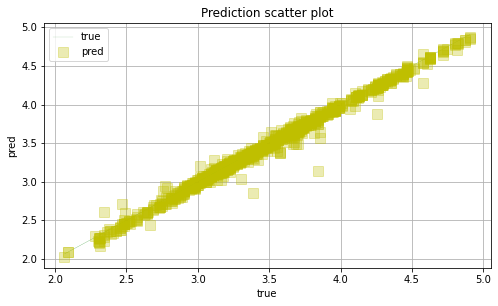

In [20]:
y_true = unit.flatten()
y_pred = model.predict([vox_list,mat,vol]).flatten()

plt.figure(figsize=(8,4.5))
plt.plot(y_true,y_true,'g-',ms='10',alpha=0.5)
plt.plot(y_true,y_pred,'ys',ms='10',alpha=0.3)
plt.legend(['true','pred'],loc='upper left')
plt.title('Prediction scatter plot')
plt.xlabel('true')
plt.ylabel('pred')
plt.grid(True)
plt.show()

In [21]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
for i in range(5):
  print(np.round(y_true[i],5),'-->',np.round(y_pred[i],5)) 

3.27779 --> 3.27842
2.8717 --> 2.872
3.25029 --> 3.28599
3.22545 --> 3.17862
3.13938 --> 3.10608


In [0]:
save_dir = '/content/drive/My Drive/졸업연구/3D_grad_cam/'

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 30, 30, 30, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 28, 28, 28, 1 6928        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 14, 14, 14, 1 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
def make_ax():
    fig = plt.figure(figsize=(5,4))
    fig.tight_layout()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(False)
    ax.axis('off')
    ax.view_init(220,45)
    return ax

def voxel_heatmap1(filled,n):
  print(filled.shape)
  a = '33'
  palette_ = ['#FF0000','#FF4000','#FF8000'
            ,'#FFBF00','#FFFF00','#BFFF00'
            ,'#00FFFF','#0000FF']
  palette = [x+a for x in palette_]

  levels = linspace(np.max(filled),np.min(filled),15)
  colors = np.array([[['#00ff0000']*n]*n]*n)
  for x in range(n):
    for y in range(n):
      for z in range(n):
        val = filled[x,y,z]
        if levels[0]>=val>levels[1]:
          colors[x,y,z]=palette[0]

        elif levels[1]>val>levels[2]:
          colors[x,y,z]=palette[1]

        elif levels[2]>val>levels[3]:
          colors[x,y,z]=palette[2]

        elif levels[3]>val>levels[4]:
          colors[x,y,z]=palette[3]

        elif levels[4]>val>levels[5]:
          colors[x,y,z]=palette[4]

        elif levels[7]>val>levels[8]:
          colors[x,y,z]=palette[5]

        else:
          colors[x,y,z]='#0000FF17'

  ax = make_ax()
  ax.voxels(np.ones((n, n, n)), facecolors=colors
            ,edgecolors=(50 / 255, 50 / 255, 50 / 255)
                ,linewidths=0.01)

  plt.show()


def voxel_heatmap2(filled,n,voxel):
  print(filled.shape)
  a = '89'
  palette_ = ['#FF0000','#FF4000','#FF8000'
            ,'#FFBF00','#FFFF00','#BFFF00'
            ,'#00FFFF','#0000FF']
  palette = [x+a for x in palette_]

  levels = linspace(np.max(filled),np.min(filled),10)
  colors = np.array([[['#00ff0000']*n]*n]*n)
  for x in range(n):
    for y in range(n):
      for z in range(n):
        val = filled[x,y,z]
        if levels[0]>=val>levels[1]:
          colors[x,y,z]=palette[0]

        elif levels[1]>val>levels[2]:
          colors[x,y,z]=palette[1]

        elif levels[2]>val>levels[3]:
          colors[x,y,z]=palette[2]

        elif levels[3]>val>levels[4]:
          colors[x,y,z]=palette[3]

        elif levels[4]>val>levels[5]:
          colors[x,y,z]=palette[4]

        elif levels[5]>val>levels[6]:
          colors[x,y,z]=palette[5]

        elif levels[6]>val>levels[7]:
          colors[x,y,z]=palette[6]

        elif levels[7]>val>levels[8]:
          colors[x,y,z]=palette[7]
        else:
          colors[x,y,z]='#0000FF17'


  ax = make_ax()
  ax.voxels(voxel[0,:,:,:,0]
              ,facecolors='#d0cfcf'
                ,edgecolors='k'
                ,linewidths=0.1,alpha = 0.9);
  plt.show()

  ax = make_ax()
   
  ax.voxels(voxel[0,:,:,:,0]
              ,facecolors='#d0cfcf'
                ,edgecolors='k'
                ,linewidths=0.1,alpha = 0.9);
  ax.voxels(np.ones((n, n, n)), facecolors=colors
            ,edgecolors=(50 / 255, 50 / 255, 50 / 255)
                ,linewidths=0.01)
     
  plt.show()


In [0]:
def grad_cam():
    
    img_output = model.output[:]
    
    last_conv_layer = model.get_layer('leaky_re_lu_1')
    
    grads = K.gradients(img_output,last_conv_layer.output)[0]
    
    gap_grads = K.mean(grads, axis=(0,1,2))
    
    iterate=K.function([model.input],
                      [gap_grads,last_conv_layer.output[0]])
    
    weights,feature_maps=iterate([voxel,mat_1,vol_1])
    
    for i in range(weights.shape[1]):
      feature_maps[:,:,:,i] *= weights[:,i]
    
    n = feature_maps.shape[0]
    temp=np.zeros([n,n,n])

    for i in range(weights.shape[1]):
      #temp+=relu(feature_maps[:,:,:,i])
      temp+=feature_maps[:,:,:,i]
    feature_map1 = np.asarray(temp)
    print('feature map size : ', feature_map1.shape)
    return feature_map1

In [0]:
def imshow(img):
  plt.imshow(img)
  plt.colorbar()
  plt.show()
def imshow2(feature_map1):
  fig = plt.figure(figsize=(20, 5))
  for i in [1,2,3,4,5]:
    ax = fig.add_subplot(1,5,i)
    ax.imshow(feature_map1[:,:,:][i-1],'jet')
    ax.set_xlabel("x")
    ax.set_ylabel("y")

  plt.show()
def interp_2d(img):
  #imshow(img)
  n = voxel_size
  new_img0 = np.zeros([n,n])
  h = [img[i,:] for i in range(feature_map1.shape[0])]

  def interpolation(one_d):
    mid = int(len(one_d)/2)
    a = np.linspace(one_d[0],one_d[mid],int(n/2))
    b = np.linspace(one_d[mid],one_d[-1],int(n/2))
    concat = np.concatenate([a,b])
    return concat

  for i in range(feature_map1.shape[0]):
    new_img0[i,:] = interpolation(h[i])

  v = [new_img0[:feature_map1.shape[0],i] for i in range(n)]
  for i in range(n):
    new_img0[:,i] = interpolation(v[i])
  #imshow(new_img0)
  return new_img0

def interpolation_z(z0,z1,z2,z3,z4):
    #print(r(z0),r(z1),r(z2))
    n = voxel_size
    k = 4
    a = np.linspace(z0,z1,int(n/k))
    b = np.linspace(z1,z2,int(n/k))
    c = np.linspace(z2,z3,int(n/k))
    d = np.linspace(z3,z4,int(n/k))
    concat = np.concatenate([a,b,c,d])
    #print(r(concat))
    return concat

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def overlay_gen(voxel,feature_map2):
  vox = voxel[0,:,:,:,0]
  overlay = np.zeros([32,32,32])
  for i in range(32):
    for j in range(32):
      for k in range(32):
        if vox[i,j,k] ==1:
          overlay[i,j,k] = feature_map2[i,j,k]
  return overlay

#def plot_cube1(cube,angle=320):
def plot_cube2(overlay,voxel,i):
  n=i
  cube = overlay
  vox = voxel[0,:,:,:,0]
  IMG_DIM = 32
  cube = normalize(cube)

  facecolors = cm.jet(cube)

  facecolors[:,:,:,-1] = cube
  facecolors = explode(facecolors)

  vox = explode(vox)

  filled = facecolors[:,:,:,-1] != 0

  for i in range(63):
    for j in range(63):
      for k in range(63):
        if vox[i,j,k]==0:
          filled[i,j,k] = False

  x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
  x2, y2, z2 = expand_coordinates(np.indices(np.array(vox.shape) + 1))

  for s,d in zip([30,90,240],[320,320,320]):
    fig = plt.figure(figsize=(5,5))
    ax = fig.gca(projection='3d')
    ax.view_init(s, d)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.tight_layout()

    ax.voxels(x, y, z, filled, facecolors=facecolors,edgecolors=None,alpha=1)

    plt.grid(False)
    plt.axis('off')
    plt.savefig(save_dir+y_name[n]+'_'+str(s)+'.png')
    plt.show()

SULF-A200-B100-L100-C30-D30
feature map size :  (5, 5, 5)


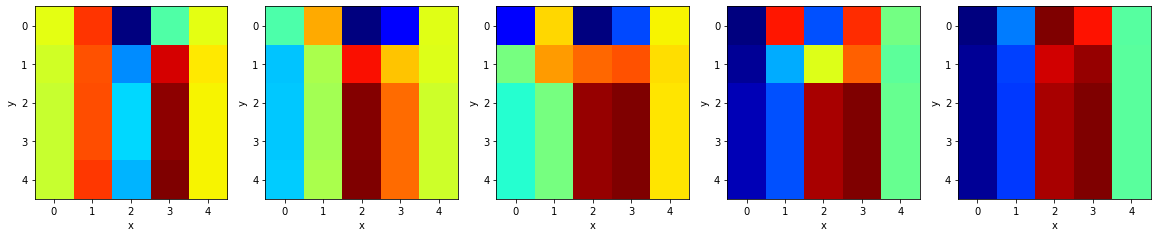

true :  81192.22222222222 pred :  75808.23692111777


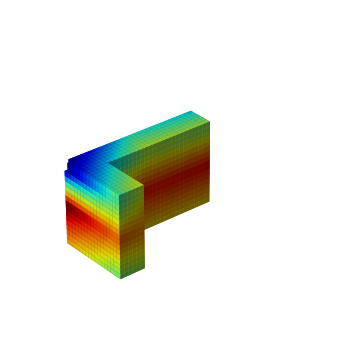

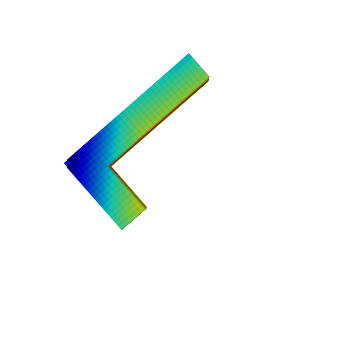

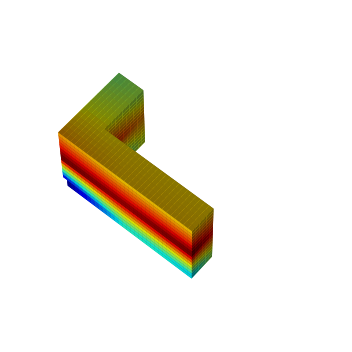

SULF-A100-B100-L190-C30-D30
feature map size :  (5, 5, 5)


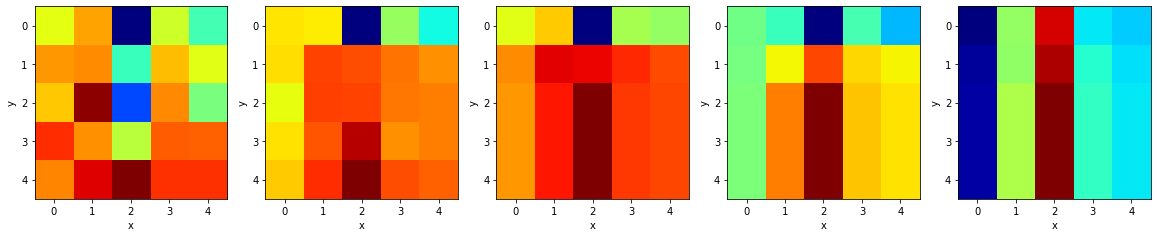

true :  81192.22222222222 pred :  70909.92958935486


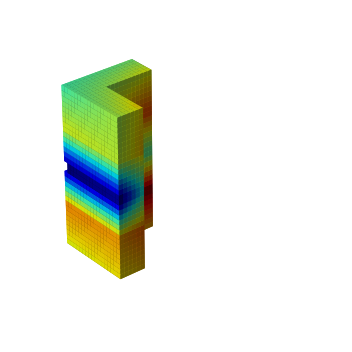

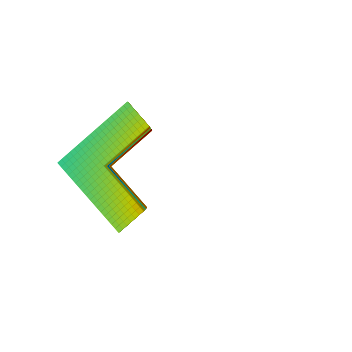

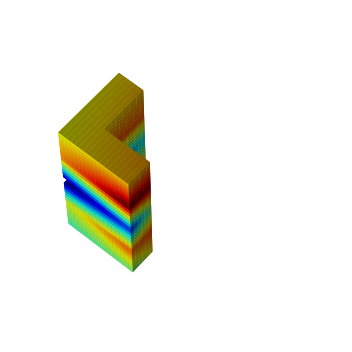

SULF-A100-B100-L200-C30-D30
feature map size :  (5, 5, 5)


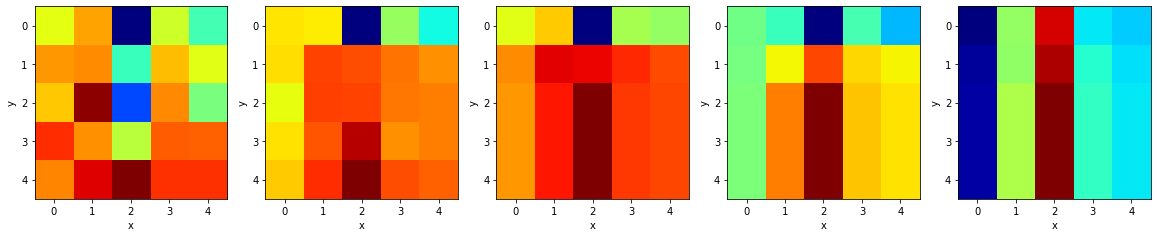

true :  81192.22222222222 pred :  72213.00179728719


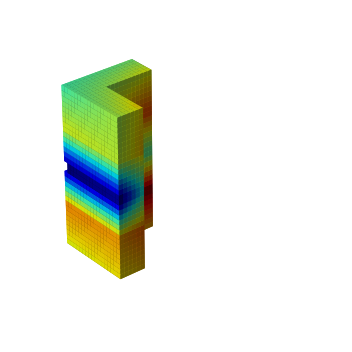

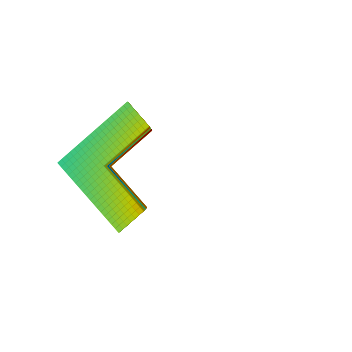

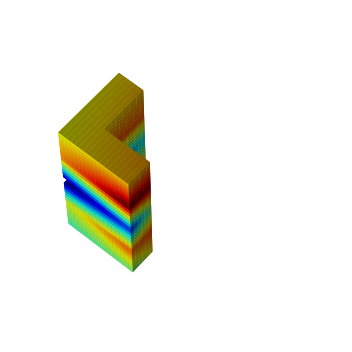

SULF-A180-B100-L100-C30-D30
feature map size :  (5, 5, 5)


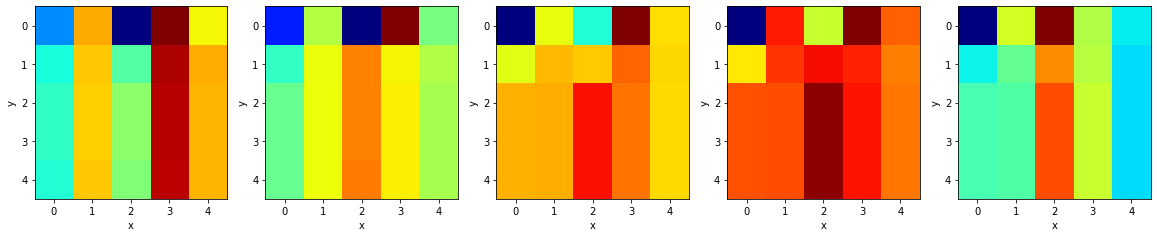

true :  74090.0 pred :  65371.032075289826


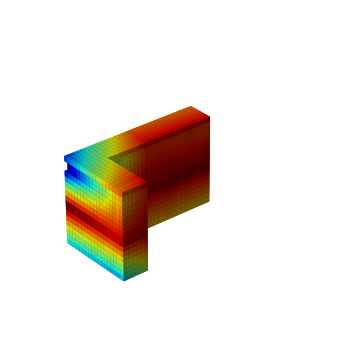

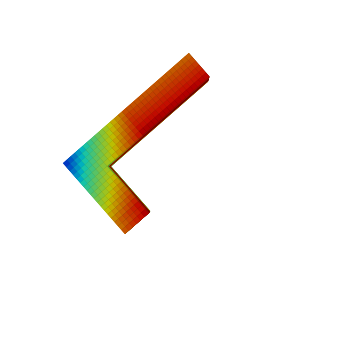

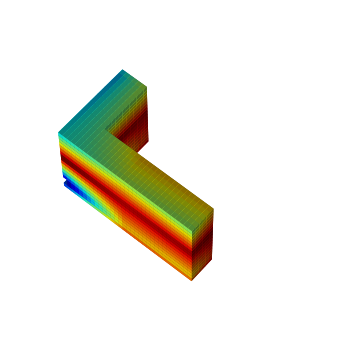

SULF-A100-B100-L170-C30-D30
feature map size :  (5, 5, 5)


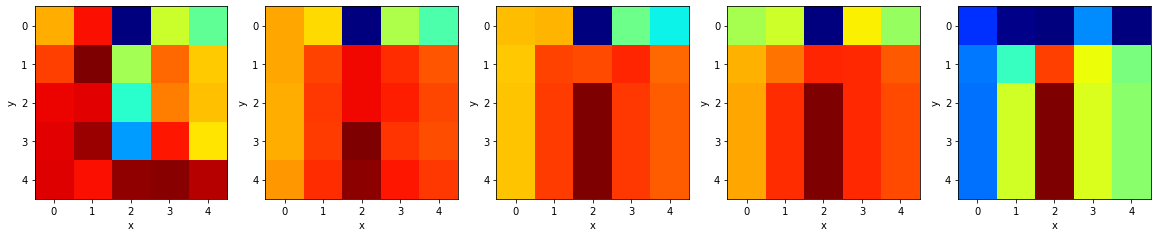

true :  74090.0 pred :  67675.12664200236


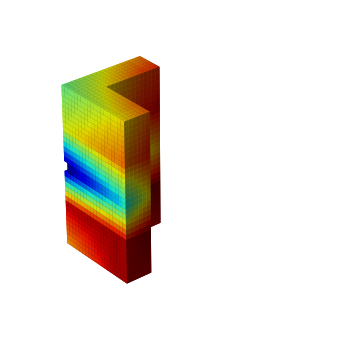

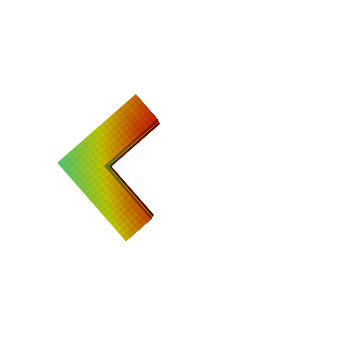

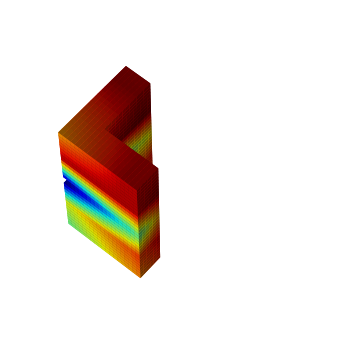

SULF-A100-B100-L180-C30-D30
feature map size :  (5, 5, 5)


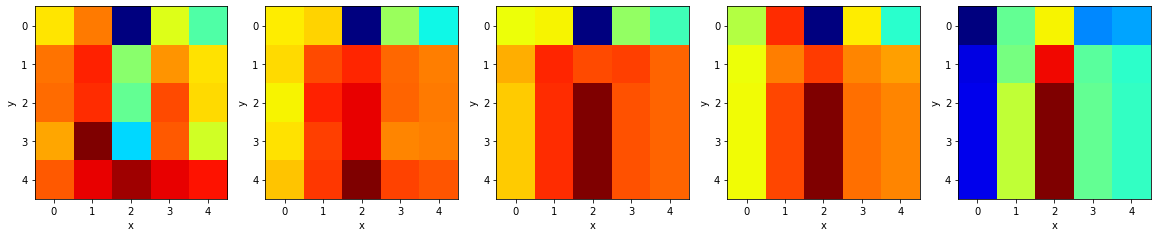

true :  74090.0 pred :  68543.24793641122


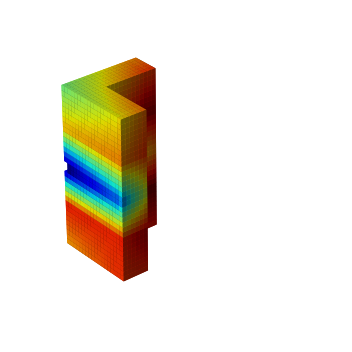

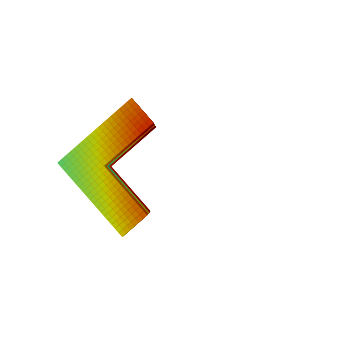

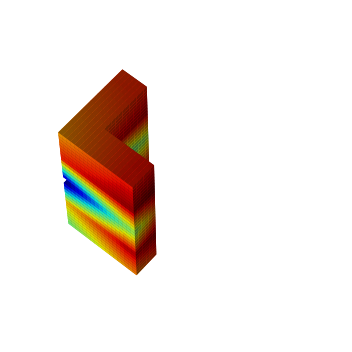

SULF-A140-B100-L100-C30-D30
feature map size :  (5, 5, 5)


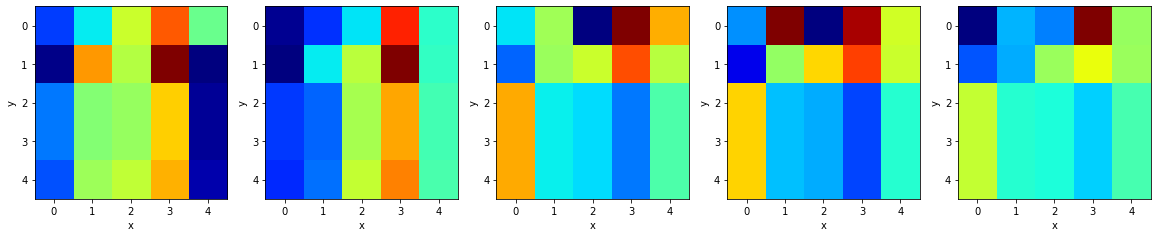

true :  67035.55555555556 pred :  60146.198504951724


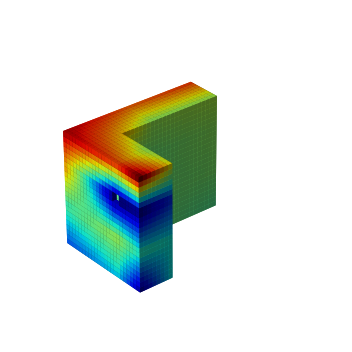

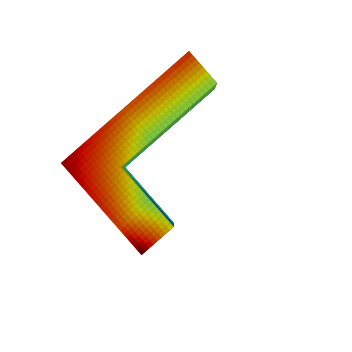

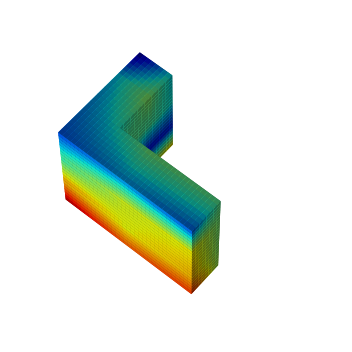

SULF-A160-B100-L100-C30-D30
feature map size :  (5, 5, 5)


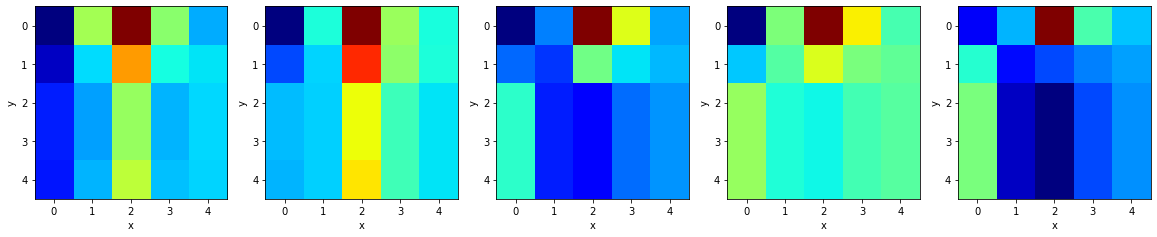

true :  67035.55555555556 pred :  63222.73502749737


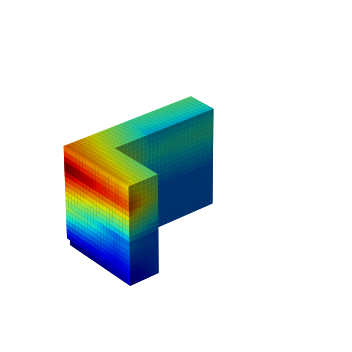

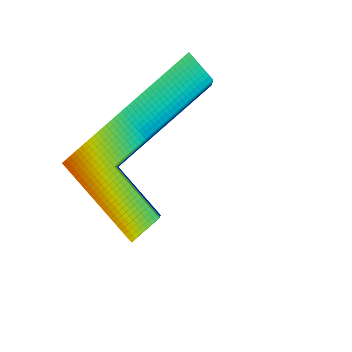

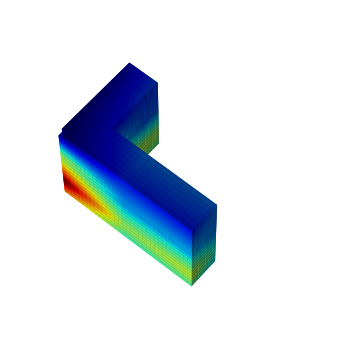

SUYF-A100-B80-L140-C30-D40-E40
feature map size :  (5, 5, 5)


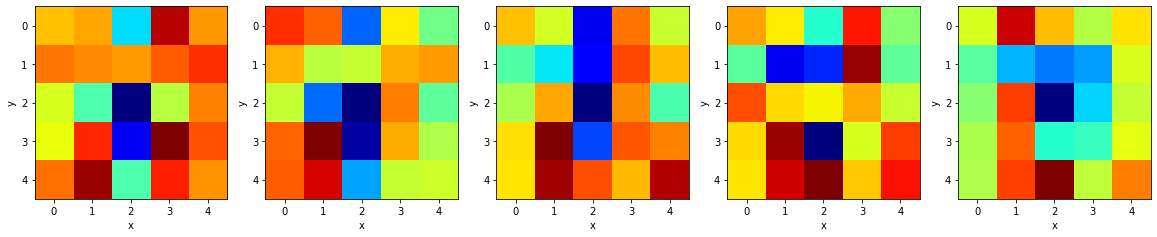

true :  65255.555555555555 pred :  51456.82045230036


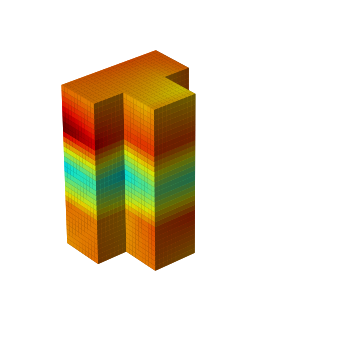

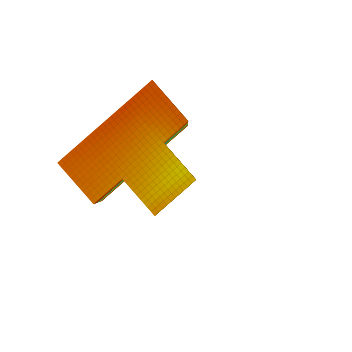

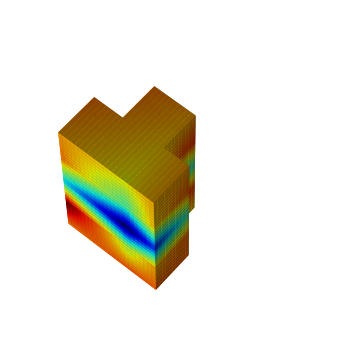

SUYF-A100-B80-L150-C30-D40-E40
feature map size :  (5, 5, 5)


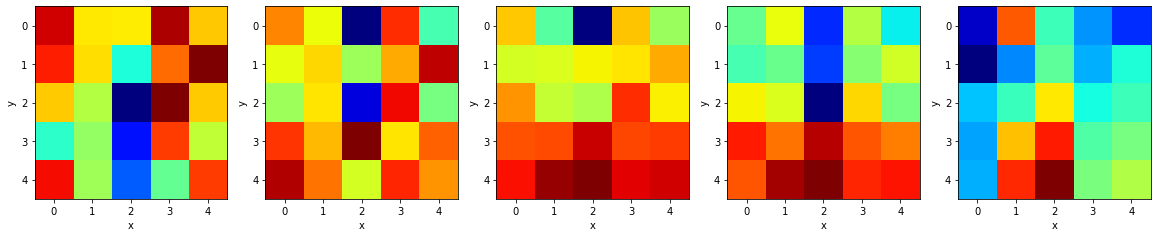

true :  65255.555555555555 pred :  62789.26769265843


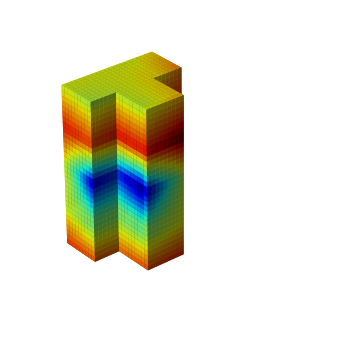

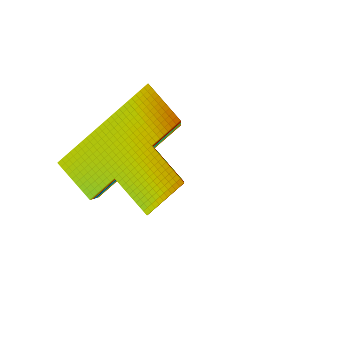

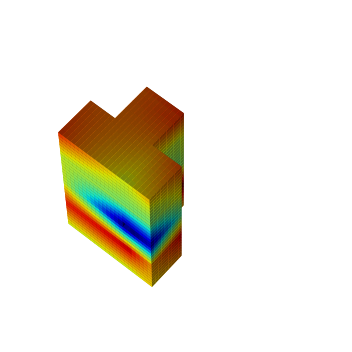

SULF-A100-B100-L140-C30-D30
feature map size :  (5, 5, 5)


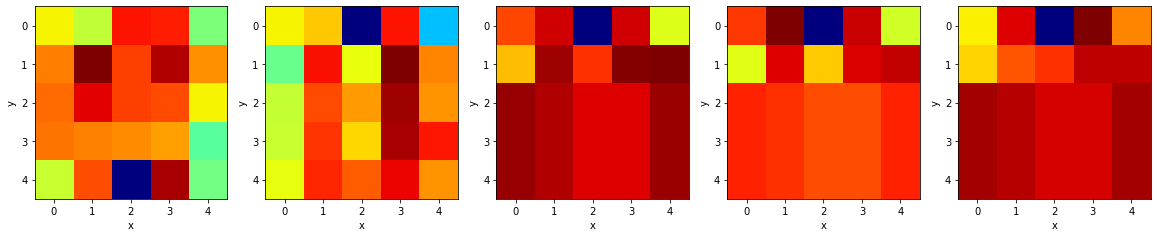

true :  63126.666666666664 pred :  58280.77805723703


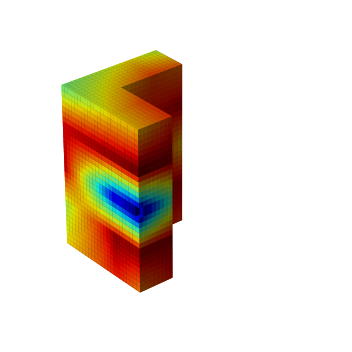

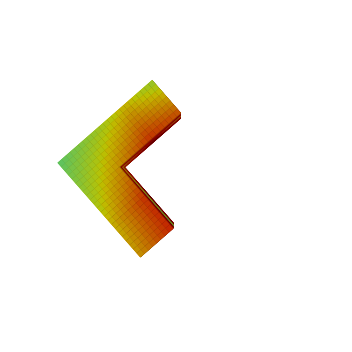

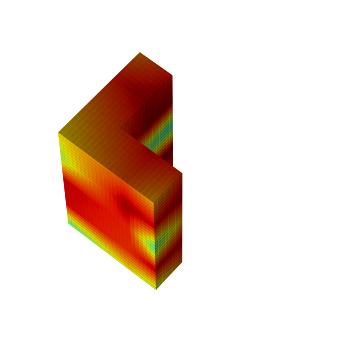

SULF-A100-B100-L150-C30-D30
feature map size :  (5, 5, 5)


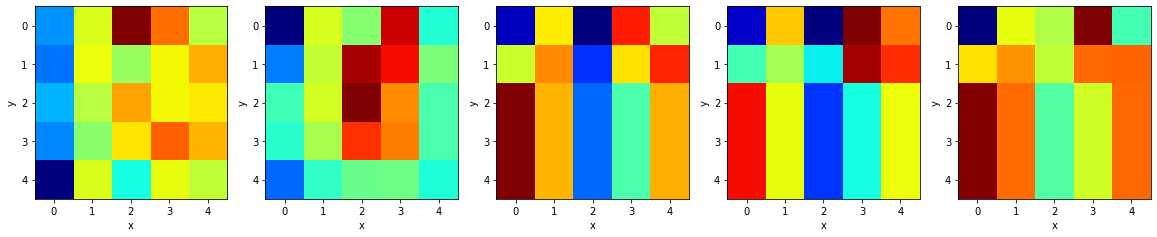

true :  63126.666666666664 pred :  61459.56435862795


In [0]:
voxel_size = 32

for index in reversed(idx):

  print(y_name[index])
  voxel = voxels[index]
  voxel = voxel.reshape(1,32,32,32,1)
  mat_1 = mat[index].reshape(1,24)
  vol_1 = vol[index].reshape(1,1)
  feature_map1 = grad_cam()
  imshow2(feature_map1)
  pred = model.predict([voxel,mat_1,vol_1])
  print('true : ',y_unit[index],'pred : ',10**pred.flatten()[0])
  a = np.zeros([voxel_size,voxel_size])
  imgs = [feature_map1[:,:,i] for i in range(feature_map1.shape[0])]
  #2d로 늘리기
  new_imgs = [interp_2d(img) for img in imgs]
  #3d로 늘리기  == > feature map2가 최종 upscale된 feature map임
  feature_map2 = np.zeros([voxel_size,voxel_size,voxel_size])
  for x in range(voxel_size):
    for y in range(voxel_size):
      z0 = new_imgs[0][x,y]
      z1 =  new_imgs[1][x,y]
      z2 =  new_imgs[2][x,y]
      z3 =  new_imgs[3][x,y]
      z4 =  new_imgs[4][x,y]
      feature_map2[x,y,:]=interpolation_z(z0,z1,z2,z3,z4)
  overlay = overlay_gen(voxel,feature_map2)
  plot_cube2(overlay,voxel,index)